In [2]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import T5Tokenizer, T5ForConditionalGeneration
from pathlib import Path

In [2]:
model_path=Path('./models')
#model="flan-t5-small-new"
tokenizer = T5Tokenizer.from_pretrained("./models/flan-t5-base-new")
#model = T5ForConditionalGeneration.from_pretrained("./models/flan-t5-small-new")

In [3]:
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()[1:-1]
            tokens = line.split(', ')
            tokens = [token.strip("'") for token in tokens]
            data.append(tokens)
    return data

#preprocess data
def preprocess_function(examples):
    inputs = tokenizer(examples['input_ids'], is_split_into_words=True, padding=False, truncation=False)
    targets = tokenizer(examples['labels'], is_split_into_words=True, padding=False, truncation=False)
        
    model_inputs = {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'labels': targets['input_ids']
    }
    return model_inputs

In [4]:
data_type="random_ns_nt"
data_path=Path('./data/train/{}'.format(data_type))

print("loading origin data ...")
train_origin_prefix = load_data(data_path/'origin_prefix_1024.txt')
print("loading simple data ...")
train_simple_prefix = load_data(data_path/'simple_prefix_1024.txt')
assert len(train_origin_prefix) == len(train_simple_prefix)
print("length of data that smaller than 1024 is: ", len(train_simple_prefix))

# split dataset for train and test
train_origin_prefix, eval_origin_prefix, train_simple_prefix, eval_simple_prefix = train_test_split(
    train_origin_prefix, train_simple_prefix, test_size=0.1, random_state=42
)
# Create dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_origin_prefix,
    'labels': train_simple_prefix
})
eval_dataset = Dataset.from_dict({
    'input_ids': eval_origin_prefix,
    'labels': eval_simple_prefix
})
dataset = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset
})
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["input_ids", "labels"], num_proc=1)

tokenized_dataset.save_to_disk(str(data_path/"preprocessed_data_t5_0<1024"))
print("preprocessed data save to disk sucessfully! ")

loading origin data ...
loading simple data ...
length of data that smaller than 1024 is:  999385


Map:   0%|          | 0/899446 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/99939 [00:00<?, ? examples/s]

Saving the dataset (0/8 shards):   0%|          | 0/899446 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/99939 [00:00<?, ? examples/s]

preprocessed data save to disk sucessfully! 


loading origin data ...
loading simple data ...
length of data that smaller than 1024 is:  999385


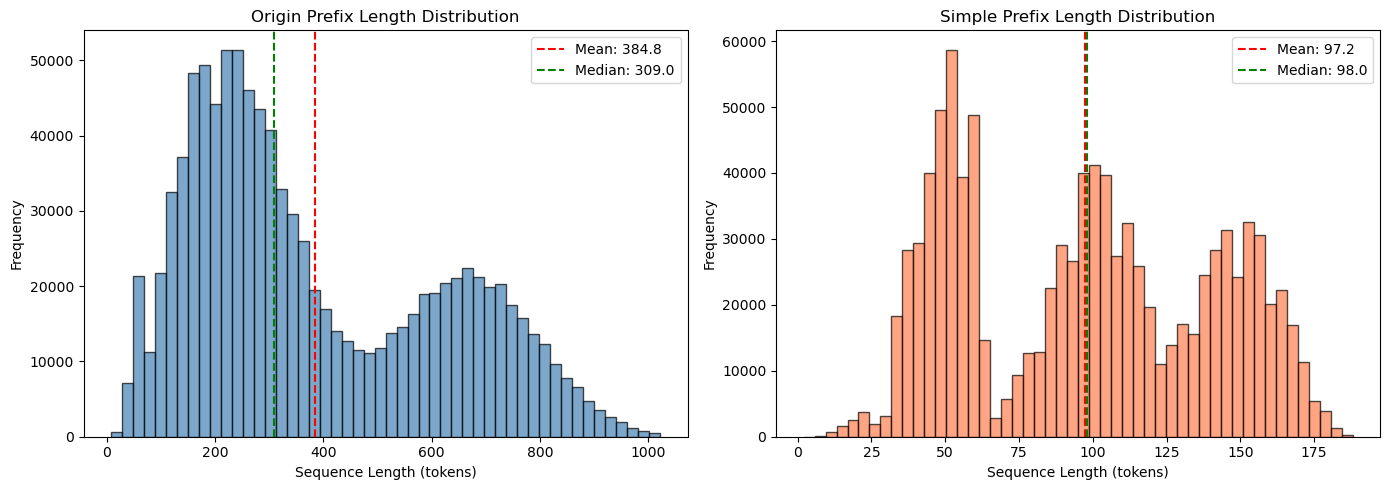

Origin Prefix - Min: 8, Max: 1022, Mean: 384.85, Median: 309.00
Simple Prefix - Min: 2, Max: 188, Mean: 97.25, Median: 98.00


In [4]:
import matplotlib.pyplot as plt
import numpy as np

data_type="random_ns_nt"
data_path=Path('./data/train/{}'.format(data_type))

print("loading origin data ...")
train_origin_prefix = load_data(data_path/'origin_prefix_1024.txt')
print("loading simple data ...")
train_simple_prefix = load_data(data_path/'simple_prefix_1024.txt')
assert len(train_origin_prefix) == len(train_simple_prefix)
print("length of data that smaller than 1024 is: ", len(train_simple_prefix))

origin_lengths = [len(seq) for seq in train_origin_prefix]
simple_lengths = [len(seq) for seq in train_simple_prefix]

# 创建图形
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 绘制origin数据长度分布
axes[0].hist(origin_lengths, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Sequence Length (tokens)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Origin Prefix Length Distribution')
axes[0].axvline(np.mean(origin_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(origin_lengths):.1f}')
axes[0].axvline(np.median(origin_lengths), color='green', linestyle='--', label=f'Median: {np.median(origin_lengths):.1f}')
axes[0].legend()

# 绘制simple数据长度分布
axes[1].hist(simple_lengths, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Sequence Length (tokens)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Simple Prefix Length Distribution')
axes[1].axvline(np.mean(simple_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(simple_lengths):.1f}')
axes[1].axvline(np.median(simple_lengths), color='green', linestyle='--', label=f'Median: {np.median(simple_lengths):.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# 打印统计信息
print(f"Origin Prefix - Min: {min(origin_lengths)}, Max: {max(origin_lengths)}, Mean: {np.mean(origin_lengths):.2f}, Median: {np.median(origin_lengths):.2f}")
print(f"Simple Prefix - Min: {min(simple_lengths)}, Max: {max(simple_lengths)}, Mean: {np.mean(simple_lengths):.2f}, Median: {np.median(simple_lengths):.2f}")

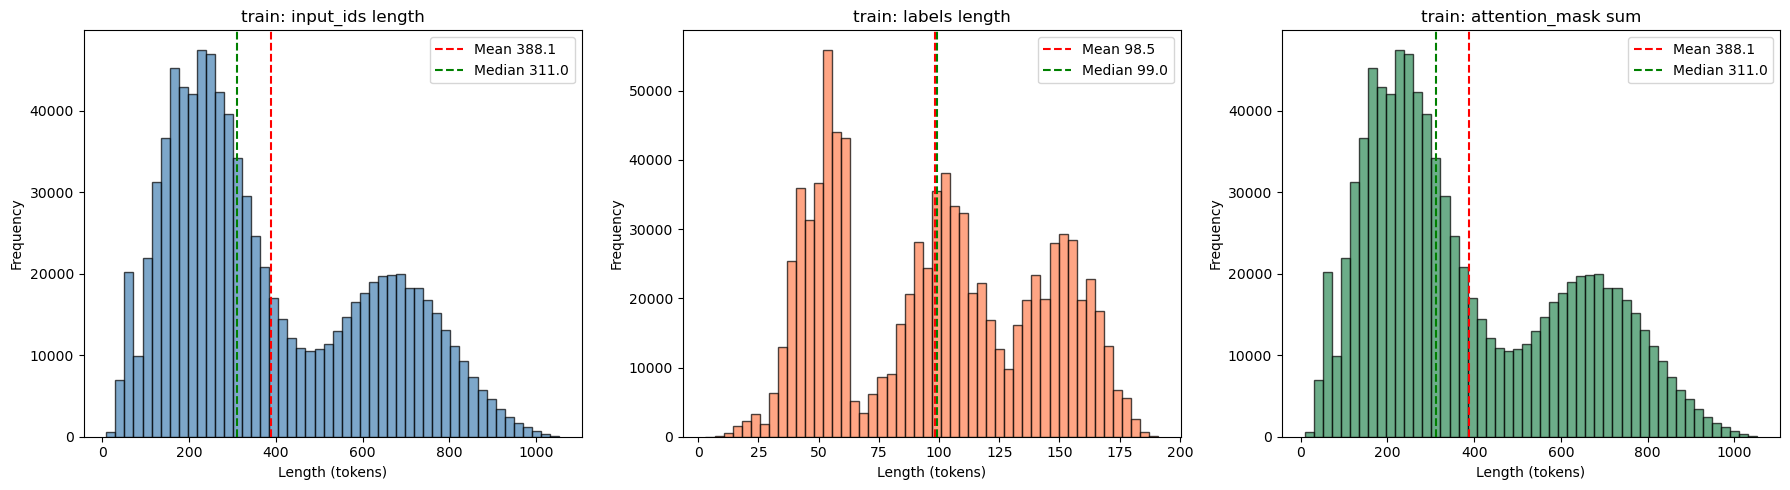

[train] input_ids  min=9 max=1053 mean=388.07 median=311.00
[train] labels     min=3 max=191 mean=98.48 median=99.00
[train] attn_sum   min=9 max=1053 mean=388.07 median=311.00


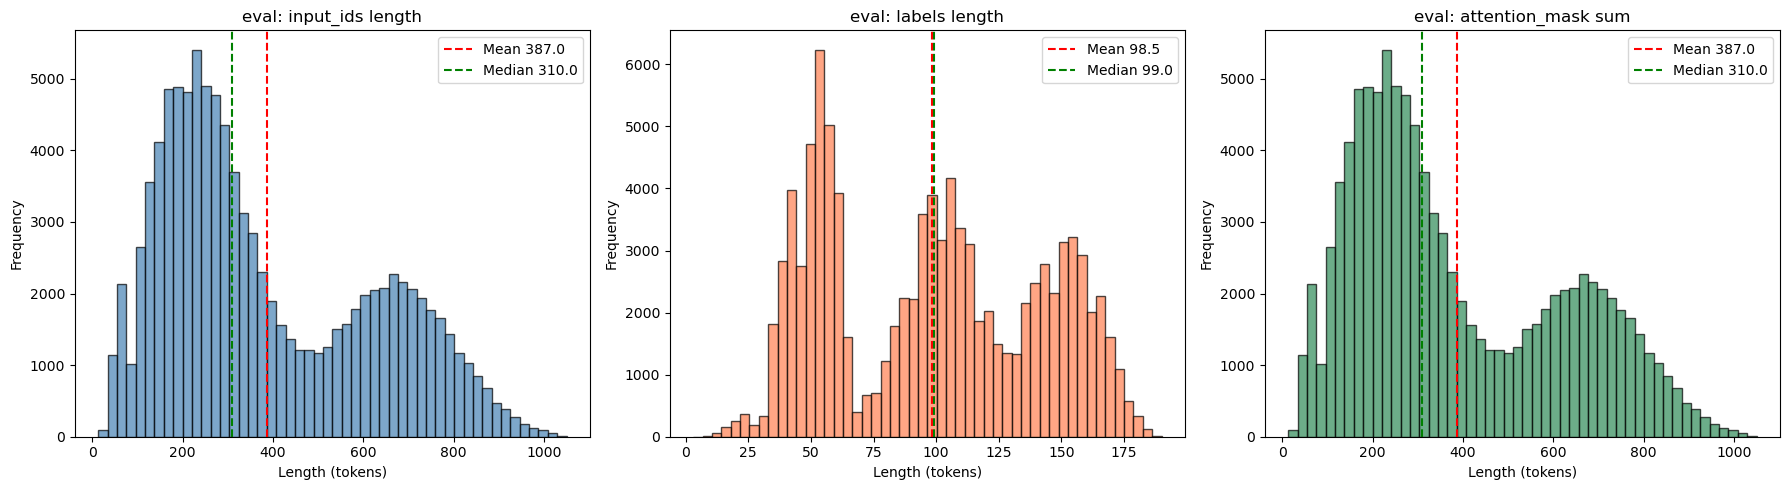

[eval] input_ids  min=13 max=1050 mean=386.96 median=310.00
[eval] labels     min=3 max=190 mean=98.47 median=99.00
[eval] attn_sum   min=13 max=1050 mean=386.96 median=310.00


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tokenized_length_dist(ds, split_name="train", bins=50):
    split = ds[split_name]

    input_lens = [len(x) for x in split["input_ids"]]
    label_lens = [len(x) for x in split["labels"]]
    attn_lens = [int(np.sum(m)) for m in split["attention_mask"]]  # 有效token数（无padding时≈input_lens）

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].hist(input_lens, bins=bins, edgecolor="black", alpha=0.7, color="steelblue")
    axes[0].set_title(f"{split_name}: input_ids length")
    axes[0].axvline(np.mean(input_lens), color="red", linestyle="--", label=f"Mean {np.mean(input_lens):.1f}")
    axes[0].axvline(np.median(input_lens), color="green", linestyle="--", label=f"Median {np.median(input_lens):.1f}")
    axes[0].legend()

    axes[1].hist(label_lens, bins=bins, edgecolor="black", alpha=0.7, color="coral")
    axes[1].set_title(f"{split_name}: labels length")
    axes[1].axvline(np.mean(label_lens), color="red", linestyle="--", label=f"Mean {np.mean(label_lens):.1f}")
    axes[1].axvline(np.median(label_lens), color="green", linestyle="--", label=f"Median {np.median(label_lens):.1f}")
    axes[1].legend()

    axes[2].hist(attn_lens, bins=bins, edgecolor="black", alpha=0.7, color="seagreen")
    axes[2].set_title(f"{split_name}: attention_mask sum")
    axes[2].axvline(np.mean(attn_lens), color="red", linestyle="--", label=f"Mean {np.mean(attn_lens):.1f}")
    axes[2].axvline(np.median(attn_lens), color="green", linestyle="--", label=f"Median {np.median(attn_lens):.1f}")
    axes[2].legend()

    for ax in axes:
        ax.set_xlabel("Length (tokens)")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    print(
        f"[{split_name}] input_ids  min={min(input_lens)} max={max(input_lens)} mean={np.mean(input_lens):.2f} median={np.median(input_lens):.2f}\n"
        f"[{split_name}] labels     min={min(label_lens)} max={max(label_lens)} mean={np.mean(label_lens):.2f} median={np.median(label_lens):.2f}\n"
        f"[{split_name}] attn_sum   min={min(attn_lens)} max={max(attn_lens)} mean={np.mean(attn_lens):.2f} median={np.median(attn_lens):.2f}"
    )



data_type="random_ns_nt"
data_path=Path('./data/train/{}'.format(data_type))

dataset1 = load_from_disk(str(data_path/"preprocessed_data_t5_0<1024"))
tokenized_dataset = DatasetDict({
    "train": dataset1["train"],
    "eval": dataset1["eval"]
})
# 看 train 分布
plot_tokenized_length_dist(tokenized_dataset, "train", bins=50)

# 如需看 eval 分布
plot_tokenized_length_dist(tokenized_dataset, "eval", bins=50)